In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')


2023-11-19 15:39:59.425565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-19 15:39:59.425588: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
test_name = '5_epochs_FL'#'descentralized_all_w_local_training_wo_global_data'
loss = 'mse'
model = 'All'
model_type = 'CNN'

datas = []
for i in ['train', 'evaluate_before_train', 'evaluate']:

    file = f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/{model_type}/{test_name}/{i}/loss_{loss}_{model}.csv'
    names = ['cid', 'round', 'loss','diff', 'anomaly', 'anomaly2']

    data = pd.read_csv(file,
                    names = names)
    
    datas.append(data)

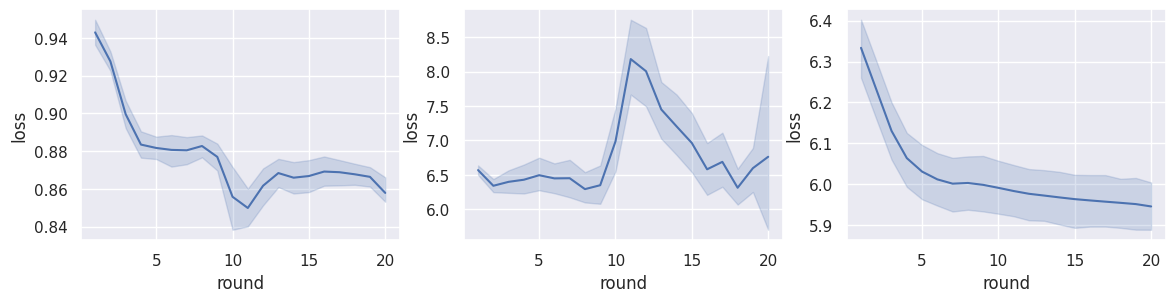

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.lineplot(datas[i], x = 'round', y = 'loss', ax = axs[i])#, hue='cid', alpha = 0.3)

<AxesSubplot:xlabel='round', ylabel='loss'>

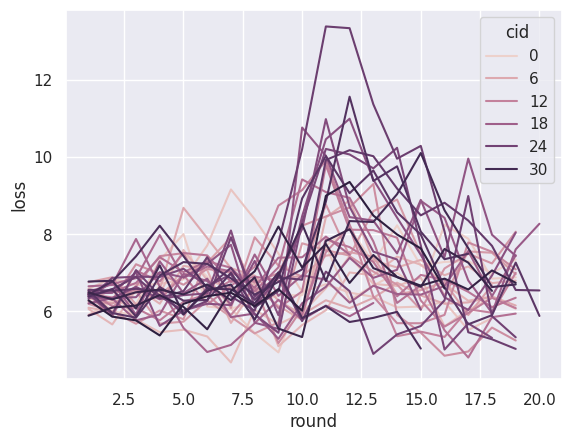

In [37]:
sns.lineplot(datas[1], x = 'round', y = 'loss', hue = 'cid')

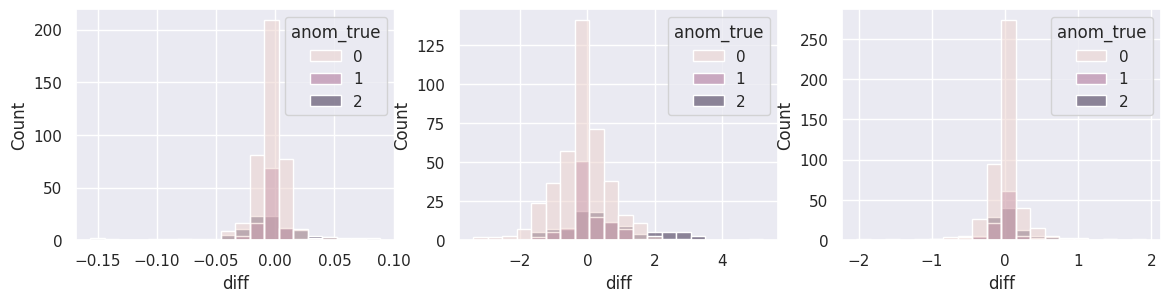

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    datas[i]['anom_true'] = datas[i]['round'].apply(lambda x: 1 if x==3 or x==4 or x==5 else (2 if x==12 or x==10 or x==11 else 0))
    sns.histplot(x = datas[i]['diff'], hue = datas[i]['anom_true'], bins = 20, ax = axs[i])

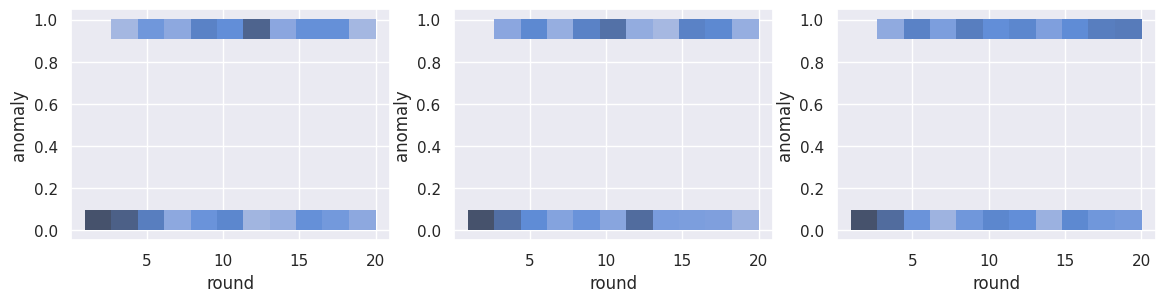

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.histplot(x = datas[i]['round'], y = datas[i]['anomaly'], ax = axs[i])#, hue = data['anom_true'], bins = 20)

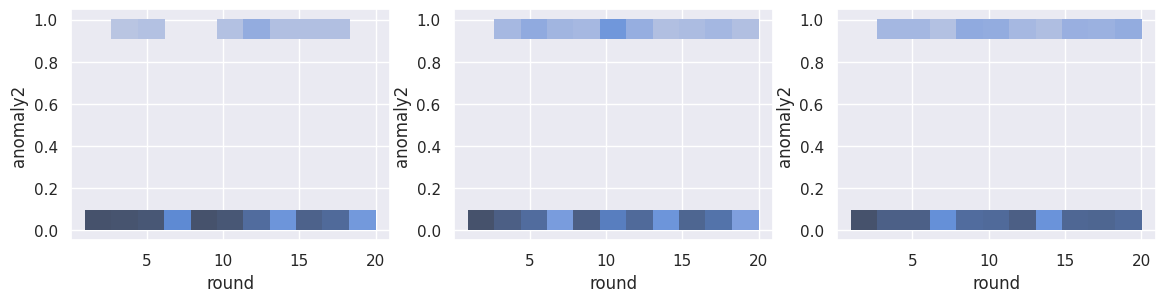

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.histplot(x = datas[i]['round'], y = datas[i]['anomaly2'], ax = axs[i])#, hue = data['anom_true'], bins = 20)

In [41]:
for i in range(3):

    data = datas[i]
    data['true_anomaly'] = data['round'].apply(lambda x: 1 if x>=9 else 0)

    data['anomaly12'] = data['anomaly'] + data['anomaly2'] 
    data['anomaly12'] = data['anomaly12'].apply(lambda x: 1 if x==2 else x)

    print('Anomaly1 ',f1_score(data['anomaly'], data['true_anomaly']),
        precision_score(data['anomaly'], data['true_anomaly']),
        recall_score(data['anomaly'], data['true_anomaly']),
        accuracy_score(data['anomaly'], data['true_anomaly']))

    print('Anomaly2 ',f1_score(data['anomaly2'], data['true_anomaly']),
        precision_score(data['anomaly2'], data['true_anomaly']),
        recall_score(data['anomaly2'], data['true_anomaly']),
        accuracy_score(data['anomaly2'], data['true_anomaly']))
    
    print('Anomaly12 ',f1_score(data['anomaly12'], data['true_anomaly']),
        precision_score(data['anomaly12'], data['true_anomaly']),
        recall_score(data['anomaly12'], data['true_anomaly']),
        accuracy_score(data['anomaly12'], data['true_anomaly']))
    
    print('-----------')



Anomaly1  0.6363636363636364 0.5664739884393064 0.725925925925926 0.6375404530744336
Anomaly2  0.15789473684210525 0.08670520231213873 0.8823529411764706 0.48220064724919093
Anomaly12  0.6473429951690821 0.5809248554913294 0.730909090909091 0.6456310679611651
-----------
Anomaly1  0.5980392156862746 0.5289017341040463 0.6879699248120301 0.6019417475728155
Anomaly2  0.3008849557522124 0.19653179190751446 0.6415094339622641 0.4886731391585761
Anomaly12  0.626771653543307 0.5751445086705202 0.6885813148788927 0.616504854368932
-----------
Anomaly1  0.6130790190735694 0.5514705882352942 0.6901840490797546 0.5823529411764706
Anomaly2  0.28849902534113064 0.18137254901960784 0.7047619047619048 0.4632352941176471
Anomaly12  0.6327077747989276 0.5784313725490197 0.6982248520710059 0.5970588235294118
-----------


In [42]:
for i in range(3):

    df = datas[i].copy()
    df['anomaly'] = 0
    df['anomaly2'] = 0
    df['anomaly3'] = 0
    df['anomaly12'] = 0

    th = 3

    for cid in range(30):
        for r in range(1, 20):

            if r>3:
                try:
                    diff = df[(df['cid'] == cid) & (df['round'] == r)]['diff'].values[0]

                    diff1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['diff'].values[0]
                    diff2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['diff'].values[0]
                    diff3 = df[(df['cid'] == cid) & (df['round'] == r-3)]['diff'].values[0]
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly = 0
                    if diff >= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly']= anomaly


                    diff = abs(df[(df['cid'] == cid) & (df['round'] == r)]['diff'].values[0])

                    diff1 = abs(df[(df['cid'] == cid) & (df['round'] == r-1)]['diff'].values[0])
                    diff2 = abs(df[(df['cid'] == cid) & (df['round'] == r-2)]['diff'].values[0])
                    diff3 = abs(df[(df['cid'] == cid) & (df['round'] == r-3)]['diff'].values[0])
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly3 = 0
                    if diff <= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly3 = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly3']= anomaly3

                    anomaly2 = 0
                    loss =  df[(df['cid'] == cid) & (df['round'] == r)]['loss'].values[0]
                    last_losses1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['loss'].values[0]
                    last_losses2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['loss'].values[0]

                    if (loss - last_losses1) > 0:
                        if (last_losses1 - last_losses2) > 0:
                            anomaly2 = 1 
                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly2']= anomaly2

                except IndexError:
                    anomaly = df[df['cid'] == cid]['anomaly'].tail(1).values[0]

    df['anomaly12'] = df['anomaly'] + df['anomaly2'] 
    df['anomaly12'] = df['anomaly12'].apply(lambda x: 1 if x==2 else x)

    df['anomaly32'] = df['anomaly2'] + df['anomaly3'] 
    df['anomaly32'] = df['anomaly32'].apply(lambda x: 1 if x==2 else x)

    data = df.copy()
    print('Anomaly',f1_score(data['true_anomaly'], data['anomaly']),
        precision_score(       data['true_anomaly'], data['anomaly']),
        recall_score(          data['true_anomaly'], data['anomaly']),
        accuracy_score(        data['true_anomaly'], data['anomaly']))

    print('Anomaly2',f1_score(data['true_anomaly'], data['anomaly2']),
        precision_score(       data['true_anomaly'], data['anomaly2']),
        recall_score(          data['true_anomaly'], data['anomaly2']),
        accuracy_score(        data['true_anomaly'], data['anomaly2']))

    print('Anomaly3',f1_score(data['true_anomaly'],  data['anomaly3']),
        precision_score(       data['true_anomaly'], data['anomaly3']),
        recall_score(          data['true_anomaly'], data['anomaly3']),
        accuracy_score(        data['true_anomaly'], data['anomaly3']))
    
    print('Anomaly32',f1_score(data['true_anomaly'], data['anomaly32']),
        precision_score(       data['true_anomaly'], data['anomaly32']),
        recall_score(          data['true_anomaly'], data['anomaly32']),
        accuracy_score(        data['true_anomaly'], data['anomaly32']))
    
    print('-----------')


Anomaly 0.6195826645264847 0.6967509025270758 0.5578034682080925 0.616504854368932
Anomaly2 0.1283422459893048 0.8571428571428571 0.06936416184971098 0.47249190938511326
Anomaly3 0.7771587743732592 0.75 0.8063583815028902 0.7411003236245954
Anomaly32 0.7760778859527121 0.7479892761394102 0.8063583815028902 0.7394822006472492
-----------
Anomaly 0.5733788395904437 0.7 0.48554913294797686 0.5954692556634305
Anomaly2 0.28181818181818186 0.6595744680851063 0.1791907514450867 0.4886731391585761
Anomaly3 0.7690140845070422 0.75 0.7890173410404624 0.7346278317152104
Anomaly32 0.7706919945725915 0.7263427109974424 0.8208092485549133 0.7265372168284789
-----------
Anomaly 0.5454545454545454 0.6788321167883211 0.45588235294117646 0.5441176470588235
Anomaly2 0.24547283702213277 0.6853932584269663 0.14950980392156862 0.4485294117647059
Anomaly3 0.744360902255639 0.7615384615384615 0.7279411764705882 0.7
Anomaly32 0.7530266343825667 0.7440191387559809 0.7622549019607843 0.7
-----------


In [43]:
Anomaly 0.5264847512038523 0.6804979253112033 0.4293193717277487 0.5489296636085627
Anomaly2 0.2978723404255319 0.7954545454545454 0.18324607329842932 0.4954128440366973
Anomaly3 0.7529107373868047 0.7442455242966752 0.7617801047120419 0.7079510703363915
Anomaly32 0.7573812580231064 0.743073047858942 0.7722513089005235 0.7110091743119266
-----------
Anomaly 0.5790297339593115 0.72265625 0.4830287206266319 0.5893129770992367
Anomaly2 0.2910602910602911 0.7142857142857143 0.18276762402088773 0.47938931297709925
Anomaly3 0.7646293888166449 0.7616580310880829 0.7676240208877284 0.7236641221374046
Anomaly32 0.7758186397984886 0.7493917274939172 0.804177545691906 0.7282442748091603
-----------
Anomaly 0.5098039215686275 0.6627450980392157 0.41421568627450983 0.5220588235294118
Anomaly2 0.22633744855967078 0.7051282051282052 0.13480392156862744 0.4470588235294118
Anomaly3 0.7527675276752768 0.7555555555555555 0.75 0.7044117647058824
Anomaly32 0.7521160822249092 0.7422434367541766 0.7622549019607843 0.6985294117647058
-----------

SyntaxError: invalid syntax (3136968688.py, line 1)